In [14]:
import os
import time
from copy import copy
from pathlib import Path
from pdb import set_trace

import matplotlib.pyplot as plt
import numpy as np
import psutil
import src.se3.visualization as viz
import torch
import torch.nn as nn
from se3_transformer_pytorch.irr_repr import rot

from src.ri_distances.SGW.risgw import RISGW_loss
from src.se3.torch_funcs import MachineScaleChecker, visualize_prediction, get_model
from src.se3.visualization import viz_point_cloud
from src.ri_distances.pnt_cloud_generation import get_src_scaled_spirals, get_src_shifted_spirals, get_spiral,center

import wandb

plt.style.use('ggplot')
model_path = Path("/content/drive/MyDrive/se3_transformer.pt")
torch.set_default_dtype(torch.float32) # works best in float64


## Machine-scale rotation-equivariance error?

In [31]:
# random rotation
Q = rot(*torch.randn(3))
transform = lambda x: x @ Q
scaler = MachineScaleChecker(transform,transformer,N=10)
scaler.get_machine_scale_error()


2.4795703684743486e-14

In [32]:
# 180 degree rotation
Q = torch.eye(3)
Q[0] *= -1
Q[1] *= -1
transform = lambda x: x @ Q
scaler = MachineScaleChecker(transform,transformer,N=10)
scaler.get_machine_scale_error()

2.0028520942433348e-14

In [33]:
 # translation
shift = (torch.rand(1,3) - 0.5) * 1000 * torch.rand(1)
transform = lambda x: x + shift
scaler = MachineScaleChecker(transform,transformer,N=3)
scaler.get_machine_scale_error()

23054.546875

## Visual Check of Translational Invariance

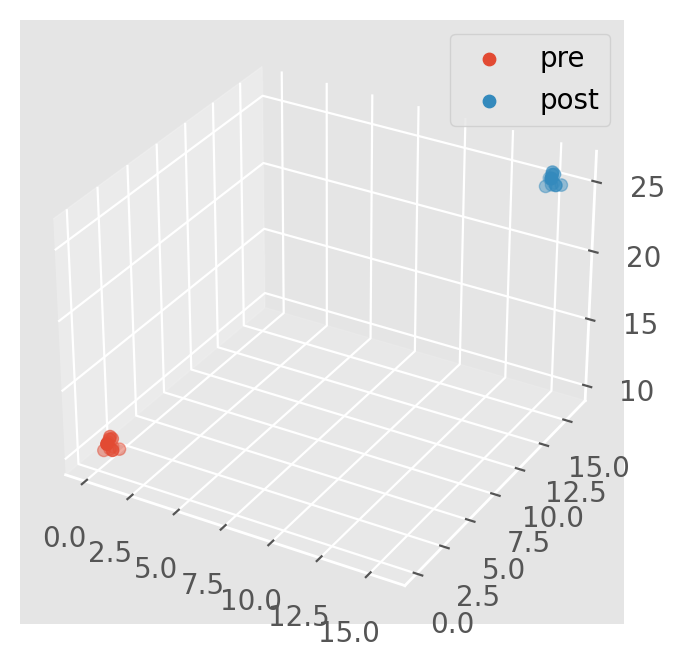

In [34]:
shift = torch.tensor([15,15,15])
points_tens = torch.rand(1,10,3) + torch.tensor([0,0,10])

# we add the shift after the prediction
post_delta_tens = predict(transformer,points_tens)
post_prediction_tens = points_tens + post_delta_tens + shift

# we add the shift before the prediction
pre_delta_tens = predict(transformer,points_tens + shift)
pre_prediction_tens = points_tens + pre_delta_tens
pre_shift, post_shift = to_numpy_array(pre_prediction_tens), to_numpy_array(post_prediction_tens)
viz_point_cloud([(pre_shift,'pre'),(post_shift,'post')])